## Loading up packages

In [1]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import copy
import numpy
import csv
import math
import pandas as pd
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from multiprocess import Pool


In [3]:
# Define the path to our Bam files
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/ecol/'
csv_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts/ecol/'
elon_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/elongation_rates/ecol/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KL_divergence/ecol/'
gtf_name = 'Escherichia_coli_str_k_12_substr_mg1655_gca_000005845.ASM584v2.51.gtf'
mutation = 'efp'
samp_num = '1'
if os.path.isfile(save_path + "kl_table_" + samp_num + ".csv") == True:
    pre_load = True
else:
    pre_load = False

## Loading up the data files 

In [4]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

In [5]:
# Remove non-protein coding transcripts from transcripts list. 
protein_coding = []
for transcript in transcripts:
    if transcript.attr['gene_biotype'] == 'protein_coding':
        protein_coding.append(transcript)

In [6]:
# clear up some memory by deleting original transcript list
transcripts.clear()

## Loading up the csv file.

In [7]:
data_mutant = kat.load_count_positions(mutation+"_RPF_"+samp_num+"_counts.csv",csv_path)
data_control = kat.load_count_positions("control_RPF_"+ samp_num +"_counts.csv",csv_path)

In [ ]:
elon_mutant = kat.load_elongation_rates(mutation + '_' + samp_num + '_elongation_rates', elon_path)
elon_control = kat.load_elongation_rates('control' + '_' + samp_num + '_elongation_rates', elon_path)

## Define functions

In [ ]:
# Calculate the smoothed density vector pbar for xth entry with length n-9
def get_pbar_from_count(tr_m):
    M = sum(tr_m)
    p = tr_m/M
    x=0
    pbar=[]
    for px in p:
        pbar_x = 0.1*sum(p[x:x+10]) #it is x+10 not x+9 because python does not include the final index.
        pbar.append(pbar_x)
        x = x+1
        if x  == len(p)-9:
            break
    pbar = np.array(pbar)
    return(pbar)

In [ ]:
_SQRT2 = np.sqrt(2) 

def hellinger3(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

## Run the hellinger Distance basic method for all transcripts

In [70]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == True:
    hd_list = []
    gene_list = []
    tr_id = []
    for tr_m, tr_c, transcript, i in zip(data_mutant,
                    data_control, protein_coding, list(range(len(data_mutant)))):
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5:
            position = np.array(list(range(len(tr_m))))
            sm_m, cumul_m = kat.get_smoothed_vector(position, tr_m+0.000001)
            sm_c, cumul_c = kat.get_smoothed_vector(position, tr_c+0.000001)
            for d, i in zip(sm_m, list(range(len(sm_m)))):
                if d < 0:
                    sm_m[i] = 0.000000000000000000001
            for d, i in zip(sm_c, list(range(len(sm_c)))):
                if d < 0:
                    sm_c[i] = 0.000000000000000000001
            hd = hellinger3(sm_m, sm_c)/(len(sm_m))
            hd_list.append(hd)
            gene_list.append(transcript.attr["gene_name"])
            tr_id.append(transcript.get_name())
            
    # reorganizing the lists into a dataframe. 
    df_b = pd.DataFrame(list(zip(gene_list, tr_id, hd_list)))
    df_b.columns = ["gene_ID","transcript_ID", "hell_d"]
    #df_b.to_csv(save_path + "_table_" + samp_num + ".csv", index=False)

Text(0.5, 1.0, 'hellinger distance of all E. coli transcripts')

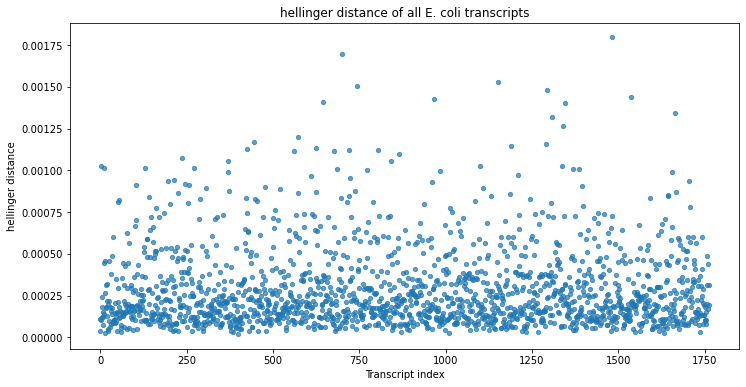

In [71]:
figure(figsize = (12,6))
plt.scatter(list(range(len(df_b["hell_d"]))), df_b["hell_d"], s=18, alpha = 0.7)
plt.ylabel("hellinger distance")
plt.xlabel("Transcript index")
plt.title("hellinger distance of all E. coli transcripts")

In [80]:
group = df_b[df_b['hell_d'] > 0.00125].groupby('gene_ID')

diff_dist = group.apply(lambda x: x['hell_d'].unique())

In [81]:
diff_dist.index

Index(['cedA', 'cnu', 'slyX', 'yebV', 'yggU', 'yhdN', 'yhdV', 'yheU', 'yidD',
       'yifL', 'yjdI', 'ypfN'],
      dtype='object', name='gene_ID')

In [82]:
len(diff_dist)

12

In [83]:
def big_dif(diff_dist, transcripts, data_mutant, data_control, figsize = (16,50), fontsize = 12):
    '''
    A function which creates a large graph showing the profile arrays for a list of transcripts
    
    returns a matplotlib axis object. 
    '''
    fig,ax = plt.subplots(len(diff_dist), 2, figsize = figsize)
    for axi, hd, gi in zip(ax, diff_dist, diff_dist.index):
            my_transcript, my_vec_mutant, my_vec_control, index = kat.find_transcripts(gi, 
                                           transcripts, data_mutant, data_control)
            maxi = max([max(my_vec_mutant), max(my_vec_control)])*1.1

            axi[0].plot(my_vec_mutant)
            axi[0].text(len(my_vec_mutant)/2, maxi/1.2, "hell_d = " + str(hd), fontsize = fontsize)
            axi[0].set_ylim([0,maxi])
            axi[0].set_ylabel("Read Counts", fontsize = fontsize)
            axi[0].set_xlabel("Codon Position", fontsize = fontsize)
            axi[0].set_title("mutant " + gi, fontsize = fontsize)
            axi[1].plot(my_vec_control)
            axi[1].set_ylim([0,maxi])
            axi[1].set_ylabel("Read Counts", fontsize = fontsize)
            axi[1].set_xlabel("Codon Position", fontsize = fontsize)
            axi[1].set_title("control " + gi, fontsize = fontsize)
    fig.tight_layout()
            
    return ax

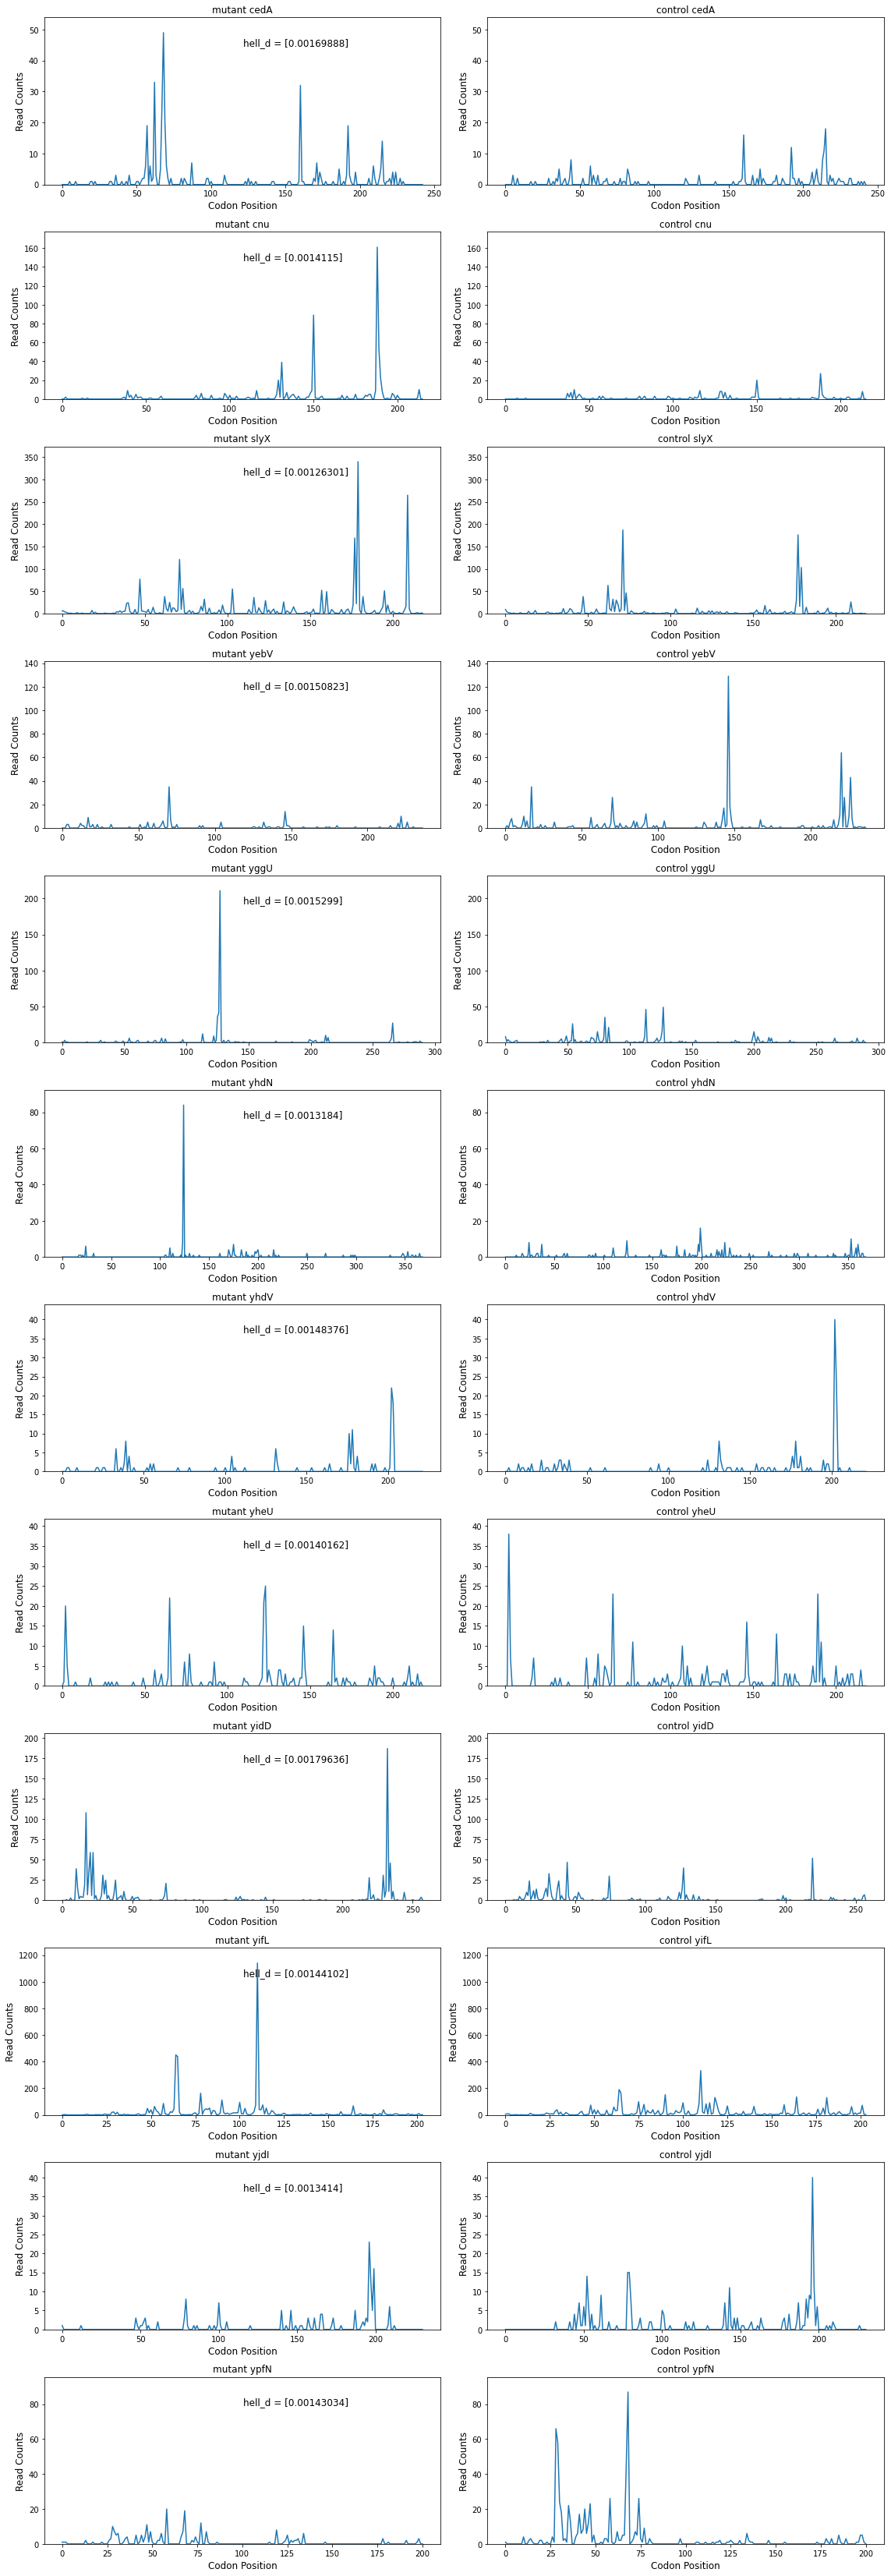

In [85]:
ax = big_dif(diff_dist, protein_coding, data_mutant, data_control, figsize = (16,46), fontsize = 12)

## Run the wasserstein distance tasep method for all transcriptsso

In [72]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == True:
    hd_list = []
    gene_list = []
    tr_id = []
    for tr_m, tr_c, el_m, el_c, transcript, i in zip(data_mutant,
                    data_control, elon_mutant, elon_control, protein_coding, list(range(len(data_mutant)))):
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5 and sum(el_c) > 0 and sum(el_m) > 0:
            altered_p = kat.alter_p(el_c, el_m)
            pbar_m = get_pbar_from_count(tr_m)
            position = np.array(list(range(len(altered_p))))
            sm_m, cumul_m = kat.get_smoothed_vector(position, pbar_m+0.000001)
            sm_p, cumul_p = kat.get_smoothed_vector(position, altered_p+0.000001)
            for d, i in zip(sm_m, list(range(len(sm_m)))):
                if d < 0:
                    sm_m[i] = 0.000000000000000000001
            hd = hellinger3(sm_m, sm_p)/(len(sm_m))
            hd_list.append(hd)
            gene_list.append(transcript.attr["gene_name"])
            tr_id.append(transcript.get_name())
            
    # reorganizing the lists into a dataframe. 
    df_t = pd.DataFrame(list(zip(gene_list, tr_id, hd_list)))
    df_t.columns = ["gene_ID","transcript_ID", "hell_d"]
    df_t.to_csv(save_path + "kl_table_" + samp_num + ".csv", index=False)

---------------------------------------------------------------------------
RuntimeWarning
invalid value encountered in sqrt
in /tmp/ipykernel_508649/1896628224.py, line 4:

3 def hellinger3(p, q):
4     return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

---------------------------------------------------------------------------


Text(0.5, 1.0, 'hellinger distance of all E. coli transcripts')

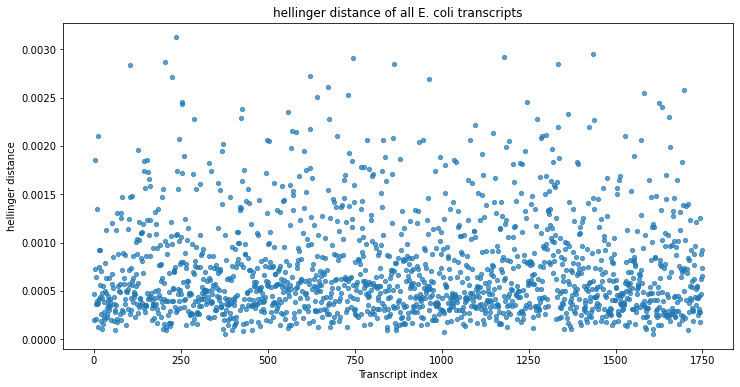

In [73]:
figure(figsize = (12,6))
plt.scatter(list(range(len(df_t["hell_d"]))), df_t["hell_d"], s=18, alpha = 0.7)
plt.ylabel("hellinger distance")
plt.xlabel("Transcript index")
plt.title("hellinger distance of all E. coli transcripts")

In [76]:
group = df_t[df_t['hell_d'] < 0.0001].groupby('gene_ID')

diff_dist = group.apply(lambda x: x['hell_d'].unique())

In [77]:
len(diff_dist)

11

In [78]:
def big_dif(diff_dist, transcripts, data_mutant, data_control, figsize = (16,50), fontsize = 12):
    '''
    A function which creates a large graph showing the profile arrays for a list of transcripts
    
    returns a matplotlib axis object. 
    '''
    fig,ax = plt.subplots(len(diff_dist), 2, figsize = figsize)
    for axi, hd, gi in zip(ax, diff_dist, diff_dist.index):
            my_transcript, my_vec_mutant, my_vec_control, index = kat.find_transcripts(gi, 
                                           transcripts, data_mutant, data_control)
            maxi = max([max(my_vec_mutant), max(my_vec_control)])*1.1

            axi[0].plot(my_vec_mutant)
            axi[0].text(len(my_vec_mutant)/2, maxi/1.2, "hell_d = " + str(hd), fontsize = fontsize)
            axi[0].set_ylim([0,maxi])
            axi[0].set_ylabel("Read Counts", fontsize = fontsize)
            axi[0].set_xlabel("Codon Position", fontsize = fontsize)
            axi[0].set_title("mutant " + gi, fontsize = fontsize)
            axi[1].plot(my_vec_control)
            axi[1].set_ylim([0,maxi])
            axi[1].set_ylabel("Read Counts", fontsize = fontsize)
            axi[1].set_xlabel("Codon Position", fontsize = fontsize)
            axi[1].set_title("control " + gi, fontsize = fontsize)
    fig.tight_layout()
            
    return ax

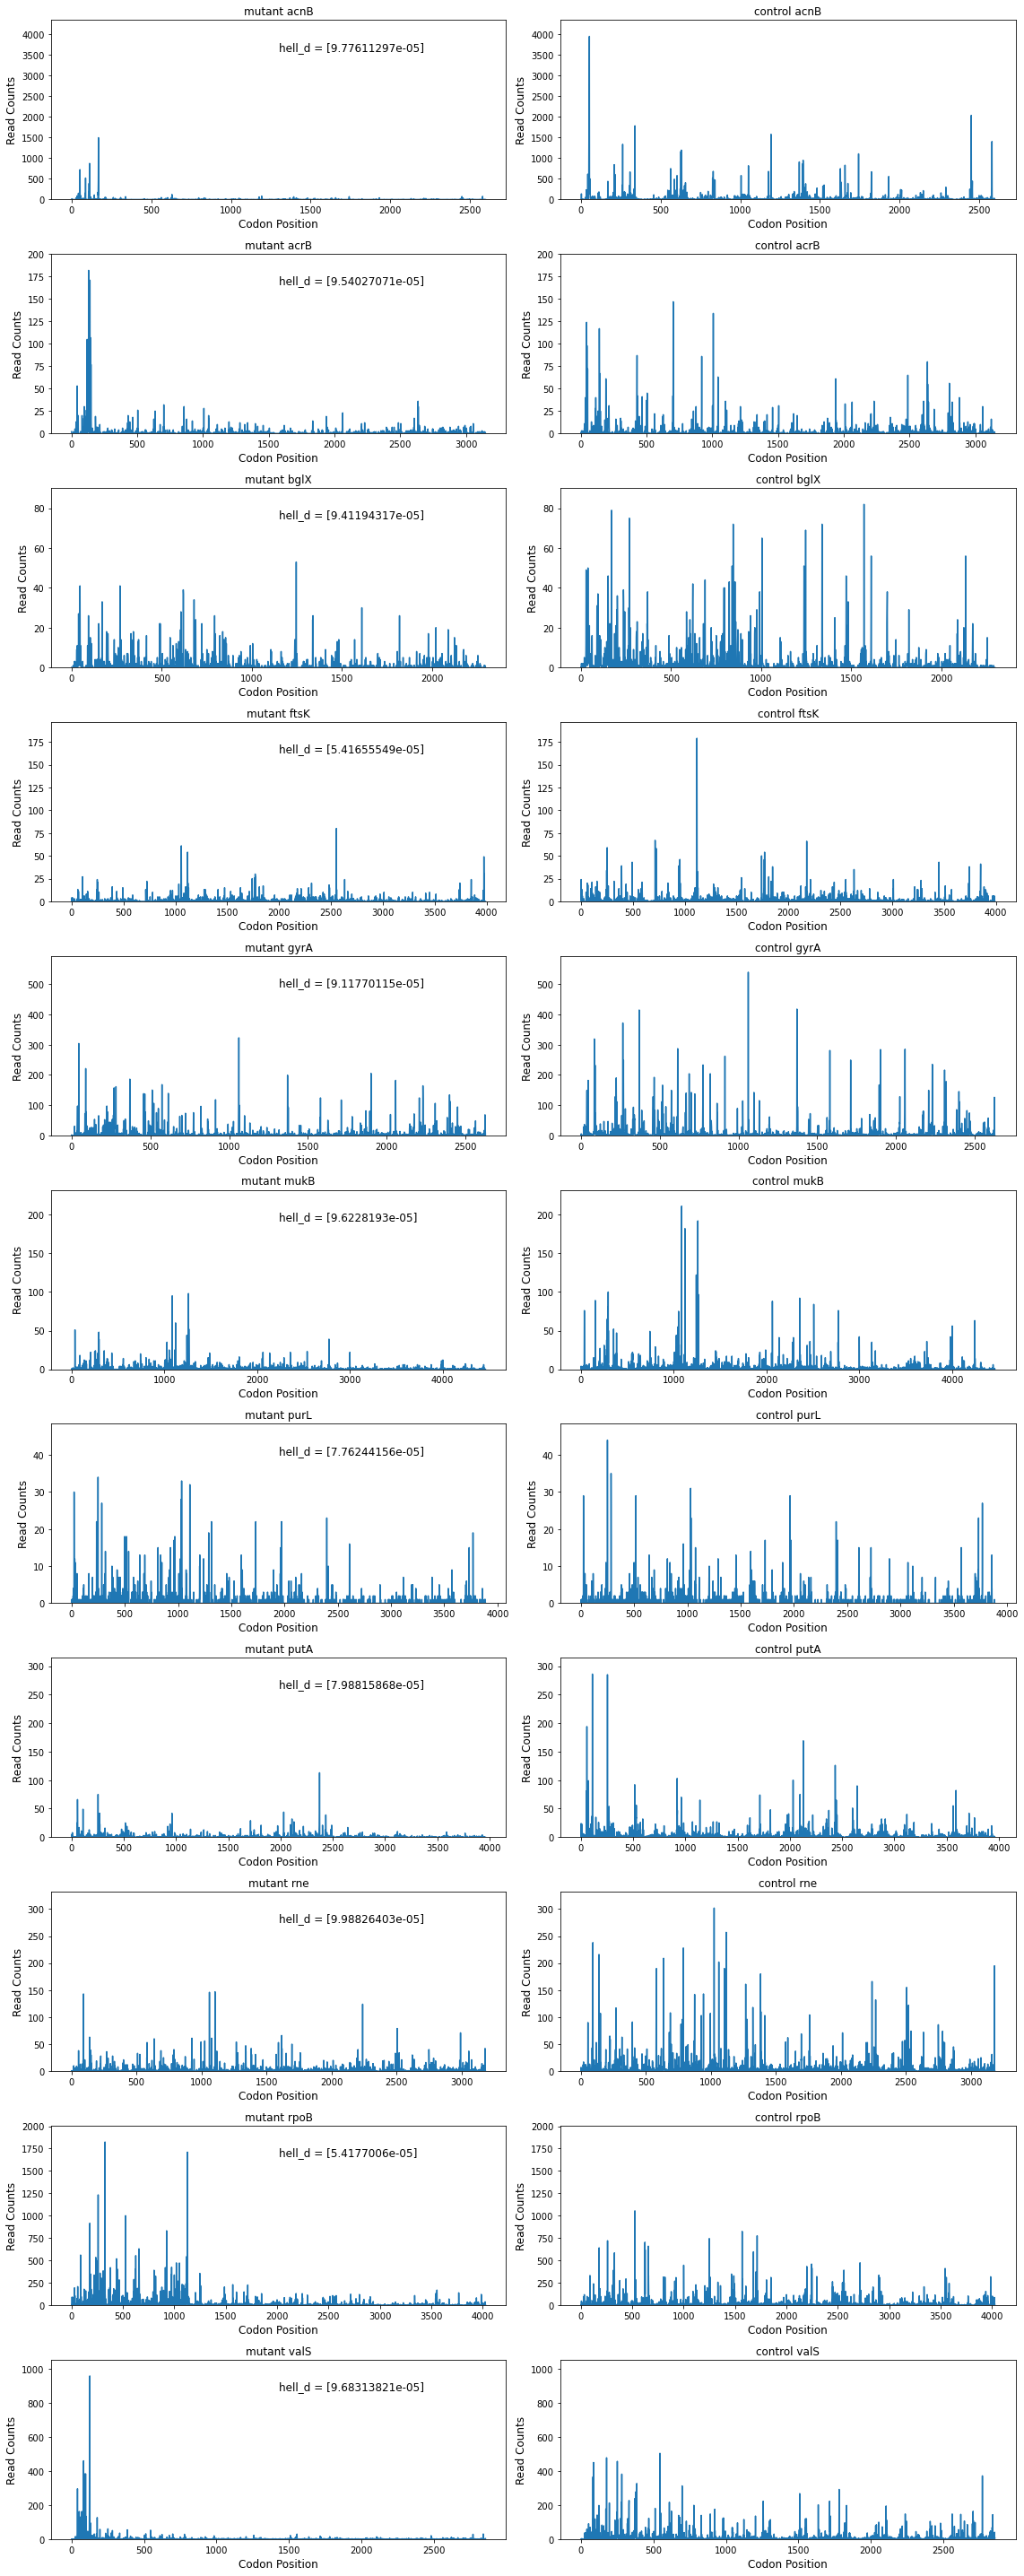

In [79]:
ax = big_dif(diff_dist, protein_coding, data_mutant, data_control, figsize = (16,40), fontsize = 12)

In [ ]:
max_pool = 15
with Pool(max_pool) as p:
    pool_outputs_m = list(
        tqdm(
            p.imap(kat.get_smoothed_vector_parallel,
                   data_control),
            total=len(frames_list)
        )
    )   

In [ ]:
kl_list

In [ ]:
kat.alter_p(elon_control[408],elon_mutant[408])

In [ ]:
elon_mutant[408]

In [ ]:
protein_coding[408].attr